In [1]:
import torch
import torch.nn as nn

from models import MaskedAutoencoderViT

In [2]:
IMAGE_SIZE = 256
PATCH_SIZE = 16
IN_CHANS = 635 # n_frames or depth, using channel for temporal dimension 
DEPTH = 4
NUM_HEADS = 2
DECODER_DEPTH = 4
DECODER_NUM_HEADS = 2
MLP_RATIO = 4
EMBED_DIM = 768
DECODER_EMBED_DIM = 524
BATCH_SIZE = 6

vit3d_ae = MaskedAutoencoderViT(img_size = 256,
                               patch_size = 16,
                               in_chans = 600,
                               depth = 4,
                               num_heads = 2,
                               decoder_depth = 4,
                               decoder_num_heads = 2,
                               mlp_ratio = 4,
                               embed_dim = 768,
                               decoder_embed_dim = 524)

In [3]:
criterion = nn.L1Loss()

In [5]:
inp_vid = torch.randn(BATCH_SIZE, 1, IN_CHANS, IMAGE_SIZE, IMAGE_SIZE)
tar_img = torch.randn(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE)
tar_pls = torch.randn(BATCH_SIZE, IN_CHANS)

In [6]:
print(f"Dimensionality of input video tensor: {inp_vid.shape}")
print(f"Dimensionality of target image tensor: {tar_img.shape}")
print(f"Dimensionality of target pulse tensor: {tar_pls.shape}")

Dimensionality of input video tensor: torch.Size([6, 1, 635, 256, 256])
Dimensionality of target image tensor: torch.Size([6, 256, 256])
Dimensionality of target pulse tensor: torch.Size([6, 635])


In [16]:
vit3d_ae = MaskedAutoencoderViT(img_size = IMAGE_SIZE,
                               patch_size = PATCH_SIZE,
                               in_chans = IN_CHANS,
                               depth = DEPTH,
                               num_heads = NUM_HEADS,
                               decoder_depth = DECODER_DEPTH,
                               decoder_num_heads = DECODER_NUM_HEADS,
                               mlp_ratio = MLP_RATIO,
                               embed_dim = EMBED_DIM,
                               decoder_embed_dim = DECODER_EMBED_DIM)

In [17]:
optimizer = torch.optim.Adam(vit3d_ae.parameters(), lr=0.001)

In [20]:
%%timeit
vit3d_ae.train()
optimizer.zero_grad()
out_vid = vit3d_ae(inp_vid)
out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
out_pls = out_vid.sum(dim=[3,4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
loss_img = criterion(out_img, tar_img)
loss_pls = criterion(out_pls, tar_pls)
loss = 0.5*loss_img + 0.5 * loss_pls
loss.backward()
optimizer.step()

3.86 s ± 717 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
920//6

153

In [22]:
153 * 4

612

In [23]:
612/60

10.2

In [9]:
inp_vid.shape

torch.Size([6, 1, 635, 256, 256])

In [19]:
out_vid.shape

torch.Size([6, 1, 635, 256, 256])

In [18]:
#print(f"Shape of decoded latent sequence: {pred.shape}")

In [123]:
# batch size = 6
# number of patches in image = 256 (img_size * img_size / patch_size^2)
# number of pixels in one path (video segment) = depth * path_size ^ 2 = 162560

In [124]:
# reshape back to video
out_vid = vit3d_ae.adaptive_unpatchify(pred)

In [125]:
out_vid.shape
# [b, depth, img_size, img_size]

torch.Size([6, 635, 256, 256])

In [126]:
# use dimensions 1 and [2,3]
out_img = out_vid.sum(dim=1, keepdim=True).squeeze(1).squeeze(1)
out_pls = out_vid.sum(dim=[2,3], keepdim=True).squeeze(1).squeeze(2).squeeze(2)

In [127]:
out_img.shape

torch.Size([6, 256, 256])

In [128]:
out_pls.shape

torch.Size([6, 635])

In [129]:
loss_img = criterion(out_img, tar_img)
loss_pls = criterion(out_pls, tar_pls)

In [130]:
loss = 0.5*loss_img + 0.5 * loss_pls

In [131]:
loss.backward()
optimizer.step()

In [132]:
635 * 16 * 16

162560

adapt solver to work with vit-3d

In [ ]:
import torch.nn as nn
from models import UNet3D, ViT3D, ProposedVnet
from torch import optim
from tqdm import tqdm
import torch
import numpy as np
from metric import calculate_mape, calculate_contrast

from vit3d_ae import MaskedAutoencoderViT

class Solver(object):
    def __init__(self, config, train_loader, valid_loader, test_loader, device):
        # Data loaders
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        # Model name
        self.model_type = "vit3d_ae"
        # Device
        self.device = device
        # Losses. Can be imported from loss.py
        self.criterion = nn.L1Loss()
        # Training params settings
        self.lr = config['training_parameters']['learning_rate']
        self.num_epochs = config['training_parameters']['epochs']
        self.batch_size = config['training_parameters']['batch_size']
        # Model initialization
        self.build_model()
    
    def build_model(self):
        self.net = MaskedAutoencoderViT(img_size = 256,
                                        patch_size = 16,
                                        in_chans = 600,
                                        depth = 4,
                                        num_heads = 2,
                                        decoder_depth = 4,
                                        decoder_num_heads = 2,
                                        mlp_ratio = 2,
                                        embed_dim = 136,
                                        decoder_embed_dim = 64)
    
        self.optimizer = optim.Adam(self.net.parameters(), self.lr)
        self.net.to(self.device)
        
    def train(self):
        best_val_loss = float('inf')
        for epoch in range(self.num_epochs):
            self.net.train()
            total_loss = 0; val_loss = 0
            for inp_vid, tar_img, tar_pls in tqdm(self.train_loader):
                self.optimizer.zero_grad()
                inp_vid, tar_img, tar_pls = inp_vid.to(self.device), tar_img.to(self.device), tar_pls.to(self.device)
                
                # check for inp_vid dimensionality
                if len(inp_vid.shape) == 5 and inp_vid.shape[1] == 1:
                    # if inp_vid.shape == [B, 1, 600, 256, 256],
                    # change it to [B, 600, 256, 256]
                    # depth or in_chans = 600
                    # img_size = 256
                    inp_vid = inp_vid.squeeze(1)
                    
                _, _, _, pred, _ = self.net(imgs = inp_vid,
                                            mask_ratio = 0.0,
                                            visible_alpha = 1.0)
                
                # pred is a [B,L,D] sequence of latent patch embeddings
                # convert it to [B, depth, img_size, img_size] tensor
                # where depth = in_chans (number of frames)
                # depth = 600 (default)
                # img_size = 256 (default)
                
                out_vid = self.net.adaptive_unpatchify(pred)
                # out_vid.shape = [B, depth, img_size, img_size]
                
                # spatial and temporal averaging
                out_img = out_vid.sum(dim=1, keepdim=True).squeeze(1).squeeze(1)
                out_pls = out_vid.sum(dim=[2,3], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
                
                # out_img.shape = [B, img_size, img_size]
                # out_pls.shape = [B, depth]
                
                loss_img = self.criterion(out_img, tar_img)
                loss_pls = self.criterion(out_pls, tar_pls)
                # Total loss. Can play with factors
                loss = loss_img# + 0.5 * loss_pls
                total_loss += loss.item()*inp_vid.size(0)
                # Optimization
                loss.backward()
                self.optimizer.step()
            
            print(f"Epoch: {epoch + 1}/ {self.num_epochs}, Loss: {total_loss/len(self.train_loader)}")
            
            # Validation after each epoch. Same as training. Save the model with least validation loss
            self.net.eval()
            with torch.no_grad():
                for inp_vid, tar_img, tar_pls in tqdm(self.valid_loader):
                    inp_vid, tar_img, tar_pls = inp_vid.to(self.device), tar_img.to(self.device), tar_pls.to(self.device)
                    
                    if len(inp_vid.shape) == 5 and inp_vid.shape[1] == 1:
                        inp_vid = inp_vid.squeeze(1)
                    
                    _, _, _, pred, _ = self.net(imgs = inp_vid,
                                                mask_ratio = 0.0,
                                                visible_alpha = 1.0)
                    
                    out_vid = self.net.adaptive_unpatchify(pred)
                    
                    out_img = out_vid.sum(dim=1, keepdim=True).squeeze(1).squeeze(1)
                    out_pls = out_vid.sum(dim=[2,3], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
                    
                    loss_img = self.criterion(out_img, tar_img)
                    loss_pls = self.criterion(out_pls, tar_pls)
                    
                    loss = loss_img#+ 0.5*loss_pls
                    val_loss += loss.item()*inp_vid.size(0)
                    
                val_loss = val_loss/len(self.valid_loader)
                print(f"Epoch: {epoch + 1} Validation Loss: {val_loss}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(self.net.state_dict(), f"model_{self.model_type}.pth")
                    print(f"Model Saved")

In [133]:
# Example tensor of shape [B, depth, img_size, img_size]
B, depth, img_size = 4, 10, 256  # Example dimensions
pred = torch.randn(B, depth, img_size, img_size)
print(pred.shape)

# Add an extra dimension
pred_expanded = pred.unsqueeze(1)  # Adds a dimension at index 1

# Check the new shape
print(pred_expanded.shape)  # Should print: [B, 1, depth, img_size, img_size]

torch.Size([4, 10, 256, 256])
torch.Size([4, 1, 10, 256, 256])


test functions

In [41]:
import yaml
import os
from dataloader import SpatioTemporalDataset, get_loader
from main import getpaths
config_path = 'config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [42]:
config["input_image_data"]["path"]

'input_image_data'

In [73]:
config['training_parameters']['batch_size']

4

In [43]:
trainfol_path, valfol_path = getpaths(config, mode='train')
testfol_path = getpaths(config, mode='test')
# Get the dataloader for each of the train valid and test sets
train_dataset, train_loader = get_loader(config, trainfol_path, mode='train')
val_dataset, val_loader = get_loader(config, valfol_path, mode='valid')
test_dataset, test_loader = get_loader(config, testfol_path, mode='test')

In [44]:
testfol_path

[['image_test/.DS_Store', 'pulse_test/.DS_Store'],
 ['image_test/Run 22 - BL4, s39708', 'pulse_test/Run 22 - BL4, s39708'],
 ['image_test/Run 26 - BL4, s39708', 'pulse_test/Run 26 - BL4, s39708'],
 ['image_test/Run 30 - BL4, s39708', 'pulse_test/Run 30 - BL4, s39708'],
 ['image_test/Run 34 - BL4, s39708', 'pulse_test/Run 34 - BL4, s39708'],
 ['image_test/Run 48 - BL4, s39708', 'pulse_test/Run 48 - BL4, s39708']]

In [37]:
dataset = SpatioTemporalDataset(config=config, mode='val', folpath=valfol_path)

In [50]:
print(f"length of train_dataset: {len(train_dataset)}")
print(f"length of train_loader: {len(train_loader)}")

length of train_dataset: 920
length of train_loader: 230


In [52]:
print(f"length of val_dataset: {len(val_dataset)}")
print(f"length of val_loader: {len(val_loader)}")

length of val_dataset: 240
length of val_loader: 60


In [54]:
print(f"length of test_dataset: {len(test_dataset)}")
print(f"length of test_loader: {len(test_loader)}")

length of test_dataset: 200
length of test_loader: 200


In [66]:
train_iter = iter(train_loader)
inp_vid, tar_img, tar_pls = next(train_iter)

In [17]:
inp_vid.shape

torch.Size([1, 1, 600, 256, 256])

In [18]:
tar_img.shape

torch.Size([1, 256, 256])

In [63]:
tar_pls.shape

torch.Size([4, 600])

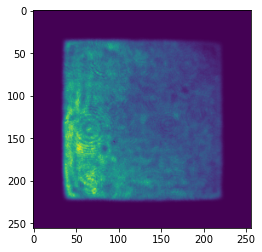

In [68]:
import matplotlib.pyplot as plt
plt.imshow(tar_img[0])

In [71]:
os.listdir()

['.DS_Store',
 'solver.py',
 'models.py',
 'input_image_data',
 'util',
 'image_test',
 'initial_vit_files',
 'config.yaml',
 'Simulated_data_physics_model',
 '__pycache__',
 'test_vit_ae.ipynb',
 'metric.py',
 'Results',
 'loss.py',
 'input_pulse_data',
 'pulse_test',
 'dataloader.py',
 '.ipynb_checkpoints',
 'main.py',
 'Simulated data - physics model.zip']

### load and test image only model

In [1]:
import torch
import torch.nn as nn
import yaml
import os
import matplotlib.pyplot as plt

from models import MaskedAutoencoderViT
from dataloader import SpatioTemporalDataset, get_loader
from main import getpaths
from torch import optim
from tqdm import tqdm

In [2]:
net = MaskedAutoencoderViT(img_size = 256,
                           patch_size = 16,
                           in_chans = 600,
                           depth = 2,
                           num_heads = 2,
                           decoder_depth = 2,
                           decoder_num_heads = 2,
                           mlp_ratio = 4,
                           embed_dim = 128,
                           decoder_embed_dim = 64)

In [3]:
config_path = 'config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
trainfol_path, valfol_path = getpaths(config, mode='train')
testfol_path = getpaths(config, mode='test')

# Get the dataloader for each of the train valid and test sets
train_dataset, train_loader = get_loader(config, trainfol_path, mode='train')
val_dataset, val_loader = get_loader(config, valfol_path, mode='valid')
test_dataset, test_loader = get_loader(config, testfol_path, mode='test')

print(f"length of train_dataset: {len(train_dataset)}")
print(f"length of train_loader: {len(train_loader)}")
print("\n")
print(f"length of val_dataset: {len(val_dataset)}")
print(f"length of val_loader: {len(val_loader)}")
print("\n")
print(f"length of test_dataset: {len(test_dataset)}")
print(f"length of test_loader: {len(test_loader)}")
print("\n")
train_iter = iter(train_loader)
inp_vid, tar_img, tar_pls = next(train_iter)
print(f"Shape of input video: {inp_vid.shape}")

length of train_dataset: 920
length of train_loader: 230


length of val_dataset: 240
length of val_loader: 60


length of test_dataset: 200
length of test_loader: 200


Shape of input video: torch.Size([4, 1, 600, 256, 256])


In [4]:
model_path = os.path.join("Results", "second_simple_run", "chck_epoch_98.pt")
checkpoint = torch.load(model_path)
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
len(test_loader)

200

In [6]:
# testiter = iter(test_loader)
inp_vid, tar_img, tar_pls = next(testiter)
inp_img = inp_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)

In [7]:
net.eval()
with torch.no_grad():
    out_vid = net(inp_vid)
    out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
    out_pls = out_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)

In [8]:
mse_loss = nn.MSELoss()

In [9]:
mse_loss(out_pls, tar_pls)

tensor(1413.5398)

In [138]:
torch.mean(torch.abs(inp_pls[0]-out_pls[0]))

tensor(127.8164)

In [142]:
inp_pls[0][0:5]

tensor([-0.0117,  0.0428, -0.0145, -0.0482, -0.0573])

In [143]:
out_pls[0][0:5]

tensor([1.6514, 0.6840, 1.2835, 0.2903, 0.8410])

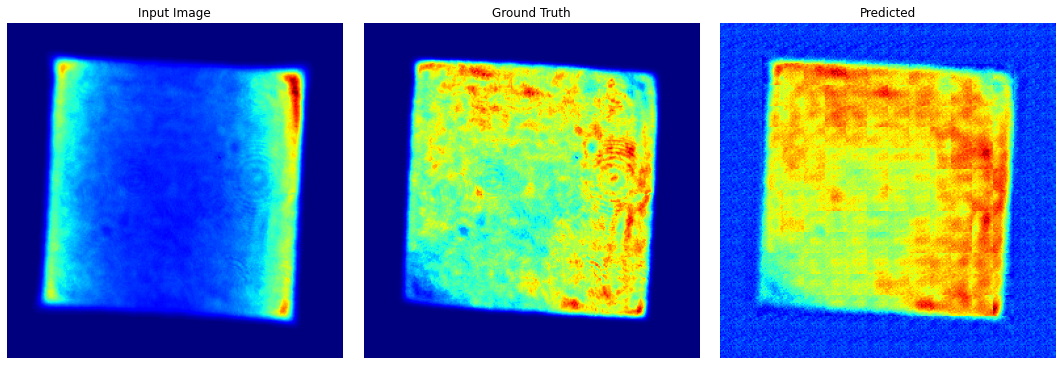

In [107]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot the input image
axs[0].imshow(inp_img[0], cmap = 'jet')  # Change index as needed
axs[0].set_title('Input Image')
axs[0].axis('off')  # Hide axes for better visualization

# Plot the ground truth image
axs[1].imshow(tar_img[0], cmap = 'jet')  # Change index as needed
axs[1].set_title('Ground Truth')
axs[1].axis('off')  # Hide axes for better visualization

# Plot the predicted image
axs[2].imshow(out_img[0], cmap = 'jet')  # Change index as needed
axs[2].set_title('Predicted')
axs[2].axis('off')  # Hide axes for better visualization

# Adjust layout
plt.tight_layout()
plt.show()

In [108]:
torch.sum(tar_img)

tensor(9650.1875)

In [109]:
torch.sum(out_img)

tensor(9618.4004)

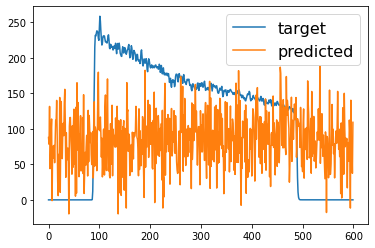

In [94]:
plt.plot(tar_pls[2], label = 'target')
plt.plot(out_pls[2], label = 'predicted')
plt.legend(fontsize=16)

### Load and test pulse only model

In [3]:
import torch
import torch.nn as nn
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from models import MaskedAutoencoderViT
from dataloader import SpatioTemporalDataset, get_loader
from main import getpaths
from torch import optim
from tqdm import tqdm

In [4]:
net = MaskedAutoencoderViT(img_size = 256,
                           patch_size = 16,
                           in_chans = 600,
                           depth = 2,
                           num_heads = 2,
                           decoder_depth = 2,
                           decoder_num_heads = 2,
                           mlp_ratio = 4,
                           embed_dim = 128,
                           decoder_embed_dim = 64)

In [5]:
config_path = 'config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
trainfol_path, valfol_path = getpaths(config, mode='train')
testfol_path = getpaths(config, mode='test')

# Get the dataloader for each of the train valid and test sets
train_dataset, train_loader = get_loader(config, trainfol_path, mode='train')
val_dataset, val_loader = get_loader(config, valfol_path, mode='valid')
test_dataset, test_loader = get_loader(config, testfol_path, mode='test')

print(f"length of train_dataset: {len(train_dataset)}")
print(f"length of train_loader: {len(train_loader)}")
print("\n")
print(f"length of val_dataset: {len(val_dataset)}")
print(f"length of val_loader: {len(val_loader)}")
print("\n")
print(f"length of test_dataset: {len(test_dataset)}")
print(f"length of test_loader: {len(test_loader)}")
print("\n")
train_iter = iter(train_loader)
inp_vid, tar_img, tar_pls = next(train_iter)
print(f"Shape of input video: {inp_vid.shape}")

length of train_dataset: 920
length of train_loader: 230


length of val_dataset: 240
length of val_loader: 60


length of test_dataset: 200
length of test_loader: 200


Shape of input video: torch.Size([4, 1, 600, 256, 256])


In [6]:
model_path = os.path.join("Results", "first_pulse_only", "chck_epoch_60.pt")
checkpoint = torch.load(model_path)
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
len(test_loader)

200

In [8]:
testiter = iter(test_loader)
inp_vid, tar_img, tar_pls = next(testiter)
inp_img = inp_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
inp_pls = inp_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)

In [9]:
net.eval()
with torch.no_grad():
    out_vid = net(inp_vid)
    out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
    out_pls = out_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)

In [10]:
mse = nn.MSELoss()

In [11]:
mse(out_pls, tar_pls)

tensor(4.6062)

In [12]:
torch.mean((out_pls - tar_pls)**2)

tensor(4.6062)

In [13]:
def get_mse_losses(loader, net):
    losses = []
    net.eval()
    with torch.no_grad():
        for inp_vid, tar_img, tar_pls in loader:
            inp_img = inp_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
            inp_pls = inp_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
            # predict
            out_vid = net(inp_vid)
            out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
            out_pls = out_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
            loss = mse(out_pls[0][24:], tar_pls[0][24:])
            losses.append(loss.numpy().item())
    return losses

In [161]:
def get_energy_differences(loader, net):
    ediffs = []
    predicted_total_energies = []
    actual_total_energies = []
    out_pulses = []
    
    
    net.eval()
    with torch.no_grad():
        for inp_vid, tar_img, tar_pls in loader:
            inp_img = inp_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
            inp_pls = inp_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
            
            # predict
            out_vid = net(inp_vid)
            out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
            out_pls = out_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
            
            #out_pls = out_pls[0][24:]
            #tar_pls = tar_pls[0][24:]
            
            pred_total_energy = 0.025*sum(out_pls[0][24:])
            actual_total_energy = 0.025*sum(tar_pls[0][24:])
            
            predicted_total_energies.append(pred_total_energy.numpy().item())
            actual_total_energies.append(actual_total_energy.numpy().item())
            
            ediff = abs(sum(out_pls[0][24:])-sum(tar_pls[0][24:]))*0.025
            ediffs.append(ediff.numpy().item())
            
            out_pulses.append(out_pls[0][24:])
            
    return ediffs, predicted_total_energies, actual_total_energies, out_pulses

In [67]:
print(f"shape of output pulse tensor: {out_pls.shape}")
print(f"shape of target pulse tensor: {tar_pls.shape}")

shape of output pulse tensor: torch.Size([1, 600])
shape of target pulse tensor: torch.Size([1, 600])


In [158]:
# out_pls[0][24:]

In [69]:
losses = get_mse_losses(loader = test_loader,
                        net = net)

In [70]:
np.mean(losses)

2.603627288341522

In [72]:
np.std(losses)

0.6313843552227331

{'whiskers': [<matplotlib.lines.Line2D at 0x172698a90>,
 'caps': [<matplotlib.lines.Line2D at 0x172698ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1726987c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1726a44c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1726a4790>],
 'means': []}

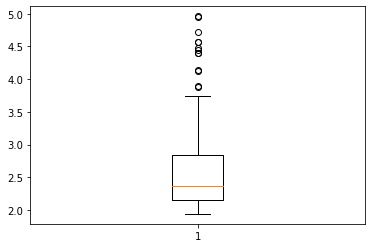

In [73]:
plt.boxplot(losses)

In [162]:
ediffs, predicted_total_energies, actual_total_energies, out_pulses = get_energy_differences(loader = test_loader,
                                                                                             net = net)

In [75]:
for pred, actual in zip(predicted_total_energies, actual_total_energies):
    #actual = actual * 0.025
    #pred = pred * 0.025
    print(f"Predicted: {pred}")
    print(f"Actual: {actual}")
    print("\n")

Predicted: -16.828231811523438
Actual: 1.0571304559707642


Predicted: 212.55712890625
Actual: 223.0203399658203


Predicted: 260.7738037109375
Actual: 270.9350280761719


Predicted: 313.2300720214844
Actual: 322.2754821777344


Predicted: 369.24609375
Actual: 376.7042541503906


Predicted: 428.1674499511719
Actual: 433.93145751953125


Predicted: 489.4303283691406
Actual: 493.6568908691406


Predicted: 552.5910034179688
Actual: 555.62353515625


Predicted: 617.3363037109375
Actual: 619.58935546875


Predicted: 683.4638061523438
Actual: 685.3414916992188


Predicted: 750.858642578125
Actual: 752.6774291992188


Predicted: -3.789555072784424
Actual: 5.322077751159668


Predicted: 819.4627075195312
Actual: 821.4267578125


Predicted: 889.2457275390625
Actual: 891.4274291992188


Predicted: 960.18017578125
Actual: 962.5326538085938


Predicted: 1032.2205810546875
Actual: 1034.608642578125


Predicted: 1105.296875
Actual: 1107.5291748046875


Predicted: 1179.3118896484375
Actual: 1181.1951

In [32]:
np.mean(ediffs)

4.763221658151597

In [33]:
np.std(ediffs)

4.394296077148169

{'whiskers': [<matplotlib.lines.Line2D at 0x1725977c0>,
 'caps': [<matplotlib.lines.Line2D at 0x172597d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x17258a4c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1725a5340>],
 'fliers': [<matplotlib.lines.Line2D at 0x1725a5610>],
 'means': []}

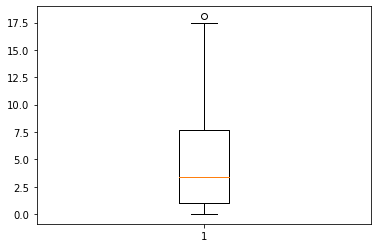

In [34]:
plt.boxplot(ediffs)

Text(0.5, 1.0, 'Power (W) vs. Time (s) for target, predicted and input pulse profiles \n (test set sample, ViT-3D Translator (Epoch 60))')

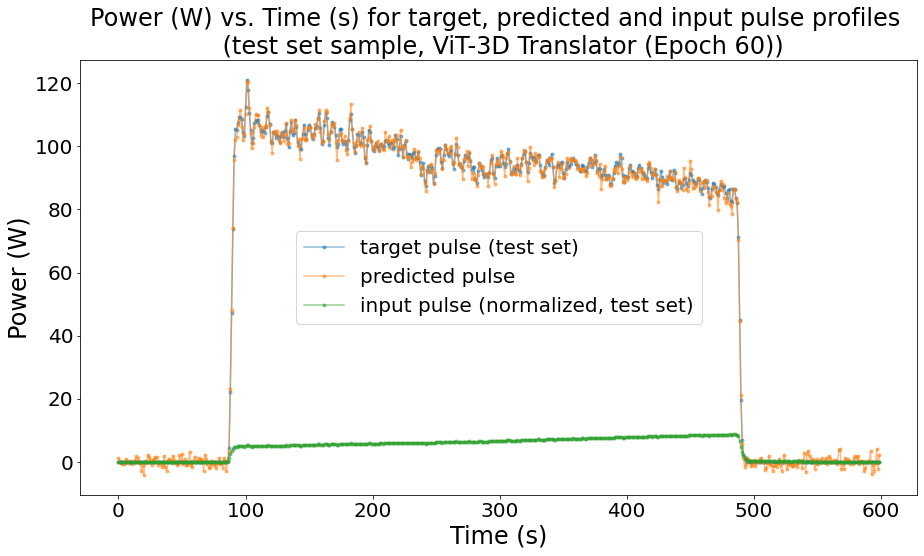

In [169]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(tar_pls[0], label = 'target pulse (test set)', alpha=0.5, marker=".")
plt.plot(out_pls[0], label = 'predicted pulse', alpha=0.5, marker='.')
plt.plot(inp_pls[0], label = 'input pulse (normalized, test set)', alpha=0.5, marker = '.')
plt.legend(fontsize=20)
plt.xlabel("Time (s)", fontsize = 24)
plt.ylabel("Power (W)", fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Power (W) vs. Time (s) for target, predicted and input pulse profiles \n (test set sample, ViT-3D Translator (Epoch 60))", fontsize = 24)

In [35]:
import pandas as pd
df = pd.DataFrame()
df["MSE"] = losses
df["Energy Difference"] = ediffs
df["Predicted Energy"] = predicted_total_energies
df["Ground Truth Energy"] = actual_total_energies

In [196]:
df.head(10)

,MSE,Energy Difference,Predicted Energy,Ground Truth Energy
0,4.720118,18.086100,-17.028954,1.057145
1,2.644582,10.582397,212.438095,223.020493
2,2.581996,10.272779,260.662415,270.935181
3,2.438645,9.150024,313.125641,322.275665
4,2.278191,7.556226,369.148224,376.704437
5,2.153147,5.855713,428.075928,433.931641
6,2.081499,4.311865,489.345215,493.657074
7,2.056643,3.111182,552.512634,555.623779
8,2.062462,2.324756,617.264893,619.589661
9,2.084356,1.941846,683.399902,685.341736


In [99]:
df.to_csv("revised_vit3d_translator_metrics.csv")

In [115]:
my_set = set([round(p,2) for p in actual_total_energies])

In [101]:
anjaly_data = pd.read_csv('finaltesting_results_d.csv')

In [182]:
anjaly_data.head(10)

,Run,File,MSE,Predicted Energy,Ground Truth Energy,Energy Difference
0,22,1,0.495609,3.095489,1.057130,2.038359
1,22,2,0.181338,5.247498,5.322078,0.074581
2,22,3,0.363837,12.685889,13.897909,1.212020
3,22,4,0.280392,30.238373,28.090238,2.148134
4,22,5,0.434353,51.027908,47.744857,3.283052
5,22,6,0.238693,74.372540,73.020446,1.352094
6,22,7,0.343918,106.523840,103.512934,3.010907
7,22,8,0.332280,143.171704,138.928465,4.243240
8,22,9,0.338565,181.058044,178.901375,2.156669
9,22,10,0.323675,225.534229,223.020536,2.513692


In [102]:
anjaly_ground_energies = list(anjaly_data['Ground Truth Energy'])

In [116]:
anjaly_set = set([round(p,2) for p in anjaly_ground_energies])

In [138]:
len(my_set.intersection(anjaly_set))

197

In [165]:
my_mse_vals = list(df["MSE"])
my_ediffs = list(df["Energy Difference"])
my_predicted_energies = list(df["Predicted Energy"])
my_ground_truth_energies = list(df["Ground Truth Energy"])
my_output_pulses = out_pulses

anjaly_run_nums = list(anjaly_data["Run"])
anjaly_file_nums = list(anjaly_data["File"])
anjaly_mse_vals = list(anjaly_data["MSE"])
anjaly_predicted_energies = list(anjaly_data["Predicted Energy"])
anjaly_ground_truth_energies = list(anjaly_data["Ground Truth Energy"])
anjaly_ediffs = list(anjaly_data["Energy Difference"])

In [171]:
new_run_nums = []
new_file_nums = []
new_mse_vals = []
new_predicted_energies = []
new_ground_truth_energies = []
new_energy_differences = []
new_output_pulses = []

for i in range(len(anjaly_ground_truth_energies)):
    refined_anjaly_energy = round(anjaly_ground_truth_energies[i], 2)
    for j in range(len(my_ground_truth_energies)):
        refined_my_energy = round(my_ground_truth_energies[j], 2)
        if refined_anjaly_energy == refined_my_energy:
            new_run_nums.append(anjaly_run_nums[i])
            new_file_nums.append(anjaly_file_nums[i])
            new_mse_vals.append(my_mse_vals[j])
            new_predicted_energies.append(my_predicted_energies[j])
            new_ground_truth_energies.append(my_ground_truth_energies[j])
            new_energy_differences.append(my_ediffs[j])
            new_output_pulses.append(my_output_pulses[j])
            break

In [177]:
new_df = pd.DataFrame()
new_df["Run"] = new_run_nums
new_df["File"] = new_file_nums
new_df["MSE"] = new_mse_vals
new_df["Predicted Energy"] = new_predicted_energies
new_df["Ground Truth Energy"] = new_ground_truth_energies
new_df["Energy Difference"] = new_energy_differences

In [183]:
new_df.head(10)

,Run,File,MSE,Predicted Energy,Ground Truth Energy,Energy Difference
0,22,1,4.720118,-17.028954,1.057145,18.086100
1,22,2,3.191003,-3.982969,5.322108,9.305077
2,22,3,2.724517,10.654284,13.897954,3.243671
3,22,4,2.632583,27.438272,28.090290,0.652017
4,22,5,2.486382,47.076031,47.744946,0.668915
5,22,6,2.361804,70.374962,73.020554,2.645593
6,22,7,2.345632,98.122627,103.513054,5.390424
7,22,8,2.455440,130.922592,138.928604,8.006006
8,22,9,2.590232,169.056961,178.901535,9.844568
9,22,10,2.644582,212.438095,223.020493,10.582397


In [188]:
new_df.to_csv("sorted_vit3d_translator_metrics.csv")

In [193]:
numpy_arrays = [tensor.numpy() for tensor in new_output_pulses]

# Convert the entire list of numpy arrays into a single numpy array
final_numpy_array = np.array(numpy_arrays)

In [194]:
final_numpy_array.shape

(195, 576)

In [195]:
np.save('vit3d_translator_output_pulses.npy', final_numpy_array)

In [197]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [199]:
count_trainable_params(net)

30150272

### Make histogram and plot distribution of MSE

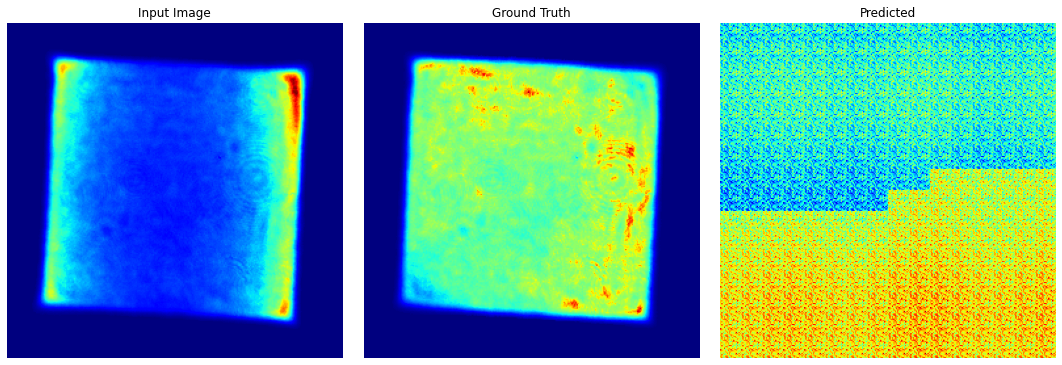

In [13]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot the input image
axs[0].imshow(inp_img[0], cmap = 'jet')  # Change index as needed
axs[0].set_title('Input Image')
axs[0].axis('off')  # Hide axes for better visualization

# Plot the ground truth image
axs[1].imshow(tar_img[0], cmap = 'jet')  # Change index as needed
axs[1].set_title('Ground Truth')
axs[1].axis('off')  # Hide axes for better visualization

# Plot the predicted image
axs[2].imshow(out_img[0], cmap = 'jet')  # Change index as needed
axs[2].set_title('Predicted')
axs[2].axis('off')  # Hide axes for better visualization

# Adjust layout
plt.tight_layout()
plt.show()

In [166]:
torch.sum(tar_img)

tensor(14782.0059)

In [167]:
torch.sum(out_img)

tensor(20131.4727)